In [1]:
import torch  # PyTorch for deep learning
import numpy as np  # NumPy for numerical operations
import pandas as pd  # Pandas for data manipulation
import re  # Regular expressions for text processing and replaces a string to match a regular expression.
import tensorflow as tf  # TensorFlow (not used in this script, but imported. 
import evaluate  # Library for evaluation metrics from  Hugging Face used to compute evaluation metrics like recall, precision, and accuracy.
#Hugging Face - A company that provides state-of-the-art models, datasets, and tools for building ML models.
import seaborn as sns  # Seaborn for data visualization
import matplotlib.pyplot as plt  # Matplotlib for plotting
import warnings  # To suppress warnings

# Import Hugging Face Transformers components.
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
#T5Tokenizer- Tokenizes input text into IDs so that the T5 model can understand. 
#T5ForConditionalGeneration- Pretrained model for text generation, summarization, translation, and question answering.
#Seq2SeqTrainingArguments- Defines training setting for seq-seq models like T5
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config
#Seq2SeqTrainer- Provides specialized training for seq2seq models like T5 and works with Seq2SeqTrainingArguments.
#DataCollatorForSeq2Seq- Batches multiple models together for training.
#TrainerCallback- Customizes training behavior by adding hooks at different stages which can be used to save logs.
#T5Config- Defines the hyperparameters and architecture of a T5 model.

# Import datasets for handling data
from datasets import Dataset #Huge datasets for building NLP models, audio, and vision models.

# Import scikit-learn for train-test split
from sklearn.model_selection import train_test_split

# Import PyTorch components for loss, optimization, and data handling
from torch.nn import CrossEntropyLoss #Loss function for multi-class classification problems. Applies softmax automatically.
from torch.optim import AdamW #Optimizer that updates model parameters during training. It correctly applies weight decay to prevent overfitting.
#AdamW does not modify gradients.
#It is a variation of Adam with weight decay improvement. Adam applies L2 regularization which does not correctly decouple weight decay from optimization.

from torch.utils.data import TensorDataset #Used with DataLoader for efficient data loading during training. 
#It combines input features x and labels y into the same dataset and enables easy data handling using dataloader.

from torchsummary import summary #Pytorch utility for summarizing the model's architecture.

# Import defaultdict for handling dictionaries with default values. Automatically assigns a value to a key if it is accessed.
from collections import defaultdict #Prevents KeyErrors

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset from a CSV file
df = pd.read_csv("medquad.csv")

# Display a sample of the data to understand its structure
print("Data Sample:")
print(df.head())

# Check for null values in the dataset
print("Null Value Data:")
print(df.isnull().sum())

# Define a list of common question words to filter relevant questions
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Convert all questions to lowercase for consistent filtering
df['question'] = df['question'].str.lower()

# Filter rows where the question starts with one of the question words
df = df[df['question'].str.split().str[0].isin(question_words)]

# Reset the index after filtering
df = df.reset_index(drop=True)

# Check for duplicate rows in the dataset
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows to ensure data uniqueness
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

# Drop unused columns ('source' and 'focus_area') to simplify the dataset
df = df.drop(columns=['source', 'focus_area'])

# Display dataset information (columns, data types, and non-null counts)
print("Table Info:")
print(df.info())

# Remove duplicate rows based on the 'question' and 'answer' columns
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

# Drop rows with null values in the 'question' or 'answer' columns
df = df.dropna(subset=['question', 'answer']).reset_index(drop=True)

# Fill any remaining null values with empty strings and convert to string type
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

# Define a function to clean text by removing parentheses and extra spaces
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)  # Remove text within parentheses.
    text = re.sub(r'\s+', ' ', text.strip().lower())  # Normalize spaces and convert to lowercase
    return text
#\(- matches opening parentheses, .*?- Matches any text inside the parentheses, /)- Matches closing parentheses.

# Apply the clean_text function to the 'question' and 'answer' columns
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Further clean the text by ensuring lowercase, stripping whitespace, and normalizing spaces
df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
#Lambda applies function to each row or a column in a dataset. Allows to compute and transform values efficiently.

# Check for null values again after cleaning
print("Null Value Data After Cleaning:")
print(df.isnull().sum())

# Check the number of unique questions and answers in the dataset
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

# Display dataset information and a sample of the cleaned data
print("Final Dataset Info:")
df.info()
print("Final Data Sample:")
df.head()

Data Sample:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data:
question       0
answer         5
source         0
focus_area    14
dtype: int64
Number of duplicate rows: 48
Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex

,question,answer
0,what is glaucoma ?,glaucoma is a group of diseases that can damag...
1,what causes glaucoma ?,"nearly 2.7 million people have glaucoma, a lea..."
2,what are the symptoms of glaucoma ?,symptoms of glaucoma glaucoma can develop in o...
3,what are the treatments for glaucoma ?,"although open-angle glaucoma cannot be cured, ..."
4,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...


In [3]:
# Define the model name and load the T5 configuration
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)

# Customize the configuration
config.dropout_rate = 0.1  # Set dropout rate to 0.1 for regularization. Defines dropout probability.
#Dropout- Regularization technique that sets some neurons to zero to prevent overfitting. 
#In this case, 10% of neurons are deactivated at every step.

config.feed_forward_proj = "gelu"  # Use GELU activation for the feed-forward layers.
#RELU(Rectified Linear Unit)- If neurons get stuck at zero, they might get stuck to learning.
#GELU(Gaussian Error Linear Unit)- Allows small negative values instead of putting them to zero hence smoother activation.

# Load the pre-trained T5 model with the customized configuration
model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)

# Load the tokenizer for the T5 model
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Explicitly resize the token embeddings to match the tokenizer's vocabulary size so that it allows tokenizer to be modified like adding new words.
model.resize_token_embeddings(len(tokenizer))

# Print a detailed summary of the model architecture
print("\nDetailed Model Summary:")
print("=" * 50)

def summarize_model_by_type(model):
    """
    Summarizes the model by counting the number of layers and parameters for each layer type.
    """
    layer_summary = defaultdict(int)  # Counts the number of layers by type
    param_summary = defaultdict(int)  # Counts the number of parameters by layer type

    for name, module in model.named_modules(): #Lists all layers in the model by names, used for debugging and helps in customizing pretrained model.
        layer_type = type(module).__name__  # Get the type of the current module
        layer_summary[layer_type] += 1  # Increment the count for this layer type. Counts occurences of each layer type.
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())  # Sum parameters. Counts the total parameters per layer type.

    # Print the summary table
    print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}") #<30-Makes layer type column 30 xters wide, <10-Aligns count column, <15-formats parameters counts with commas.
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)

# Define a preprocessing function for the seq2seq task
def preprocess_function(batch, tokenizer): #Adds batch and tokenizer in the function
    """
    Preprocesses the dataset by tokenizing the inputs and targets.
    """
    # Format the inputs and targets
    inputs = [f"answer the following question: {q}" for q in batch['question']] #Contains formatted prompts.
    targets = [f"{a}" for a in batch['answer']] #Contains predicted and expected answers.
    #pt-Pytorch tensors.
    #What are tensors? multi-dimensional array that serves as a fundamental data structure in ML and DL.

    #Tokenize the inputs. 
    model_inputs = tokenizer(
		inputs,
		max_length=128,
		truncation=True,
		padding="max_length",
	)
    #Tokenize the targets
    labels = tokenizer(
		targets,
		max_length=256,
		truncation=True,
		padding="max_length",
	)["input_ids"]#Extract input_ids directly

    # Replace padding token IDs with -100 for the loss function to ignore them. 
    labels = [[token if token != tokenizer.pad_token_id else -100 for token in label] for label in labels]
    model_inputs["labels"] = labels
    return model_inputs
#Why convert padded token ids to -100? T5ForConditionalGeneration uses CrossEntropyLoss for loss computation which ignores -100.

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Convert the pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

#Import partial to allow inclusion of tokenizer and preprocess function on the same line.
from functools import partial

# Wrap preprocess_function to include tokenizer
preprocess_with_tokenizer = partial(preprocess_function, tokenizer=tokenizer)

# Preprocess the training and validation datasets using the map() function.
train_dataset = train_dataset.map(
    preprocess_with_tokenizer, #Function that processes data and tokenizes the data.
    batched=True, #Apply batches to data instead of single examples; hence efficiency is maintained.
    batch_size=32,  # Process in batches of 32 at a time to allow large handling of datasets without running out of memory.
    remove_columns=train_dataset.column_names,  # Remove original columns to ensure only processed outputs(tokenized inputs) remains.
    num_proc=4,  # Use 4 processes for parallel processing to speed up data transformation.
)

val_dataset = val_dataset.map(
    preprocess_with_tokenizer, #Function that processes and tokenizes the data.
    batched=True, #Apply batches to data instead of single examples.
    batch_size=32,  # Process in batches of 32 to allow large handling of data.
    remove_columns=val_dataset.column_names,  # Remove original columns to ensure only processed output remains.
    num_proc=4,  # Use 4 processes for parallel processing to speed up data transformation.
)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",# Directory to save the model and results
    resume_from_checkpoint=True, #Let the model resume from the last checkpoint after interruption.
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_total_limit=2,  # Keep only the last 2 checkpoints.
    learning_rate=5e-4,  # Learning rate.
    num_train_epochs=5,  # Number of training epochs.
    per_device_train_batch_size=8,  # Batch size for training.
    per_device_eval_batch_size=8,  # Batch size for evaluation.
    lr_scheduler_type="cosine_with_restarts",  # Learning rate scheduler.
    warmup_ratio=0.1,  # Warmup ratio for the scheduler.
    weight_decay=0.05,  # Weight decay for regularization.
    predict_with_generate=True,  # Generate predictions during evaluation.
    fp16=True,  # Use mixed precision for faster training
    logging_dir="./logs",  # Directory for logs
    logging_steps=50,  # Log every 50 steps
    metric_for_best_model="exact_match",  # Use exact match as the primary metric
    greater_is_better=True,  # Higher exact match is better
    report_to="none",  # Disable external reporting
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    max_grad_norm=0.5,  # Gradient clipping
    optim="adamw_torch_fused",  # Use fused AdamW optimizer
    generation_max_length=64,  # Maximum length for generated text
    generation_num_beams=6,  # Number of beams for beam search
    dataloader_num_workers=0,  # Number of workers for data loading
    group_by_length=True,  # Group sequences by length for efficiency
    remove_unused_columns=True,  # Remove unused columns from the dataset
    label_smoothing_factor=0.1,  # Apply label smoothing
)

# Initialize the data collator for seq2seq tasks
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',  # Pad sequences to the longest in the batch
    return_tensors="pt",  # Return PyTorch tensors
)

# Define a function to compute evaluation metrics
def compute_metrics(eval_pred, tokenizer):
    """
    Computes exact match, BLEU, and ROUGE-L metrics for evaluation.
    """
    predictions, labels = eval_pred

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True) #Converts predicted token IDs into text.  
    # Skip_special_tokens- Removes special tokens like pad.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) #Replace -100 with pad_r=token_id to allow for decoding.
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True) #Converts predicted ground truth IDs into text.

    # Normalize text for comparison
    decoded_preds = [text.strip().lower() for text in decoded_preds] #Remove the text spaces and convert everything to lowercase.
    decoded_labels = [text.strip().lower() for text in decoded_labels] #Remove the text spaces and convert everything to lowercase.

    # Compute exact match to measure the exact match of the inputs.
    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)]) #Compares each prediction (p) to correspons=ding ground truth label 1.
    #Mean calculates the average score. Returns 1 if true otherwise false (0). Exact match is used for strictly fact-based questions where answers have to be identical.


    #BLEU - Bilingual Evaluation Understudy, ROUGE - Recall Oriented Understudy for Gisting Evaluation. 
    # Load BLEU and ROUGE metrics that measure partial matches as exact match is strict. They are flexible.
    bleu_metric = evaluate.load("bleu") #Best for ML models as it checks how well predicted phrases match.
    rouge_metric = evaluate.load("rouge") #Best for text summarization, translation, text generation, and paraphrasing. Rouge L uses Longest Common Subsequence for more flexible comparison.

    # Compute BLEU score
    bleu_score = bleu_metric.compute( #Calculates blue metrics
        predictions=decoded_preds, #List of generated text predictions
        references=[[label] for label in decoded_labels] #decoded labels is a list of ground truth. Bleu expects multiple references for each prediction hence enclosed.
    )["bleu"]

    # Compute ROUGE-L score
    rouge_score = rouge_metric.compute( #Calculates rouge score for predictions
        predictions=decoded_preds, #List of decoded text predictions
        references=decoded_labels #No need to wrap the references. Decode ground truths.
    )["rougeL"] #Extract Rouge-l score directly for Longest Common Subsequence.

    #Return exact match, BLUE, and Rouge-L scores.
    return {
        "exact_match": exact_match,
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
    }

# Initialize the Seq2SeqTrainer for specialized training.
trainer = Seq2SeqTrainer(
    model=model, #Add the model
    args=training_args, #Add the training arguments
    train_dataset=train_dataset, #Add the training dataset
    eval_dataset=val_dataset, #Add the validation dataset for train_test_split
    tokenizer=tokenizer, #Add the tokenizer
    data_collator=data_collator, #Add datacollator that batches multiple models together
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer), #Apply the compute metrics using lambda fuction.
)

# Train the model
trainer.train()

# Save the trained model and tokenizer
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")

# Save the model's state dictionary
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

# Save the training log history
log_history = trainer.state.log_history

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Detailed Model Summary:
Layer Type                    Count     Parameters     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


Map (num_proc=4): 100%|█████████████████████████████████████████████████████| 2079/2079 [00:21<00:00, 95.05 examples/s]
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,3.200800,3.035998,0.000962,0.027675,0.222536
2,2.991400,2.910582,0.000962,0.034610,0.255671
3,2.852100,2.851270,0.001443,0.038292,0.254100
4,2.734700,2.823321,0.001924,0.041055,0.265423


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


In [31]:
min_len = min(len(steps), len(train_loss), len(eval_loss))
print(min_len)

5


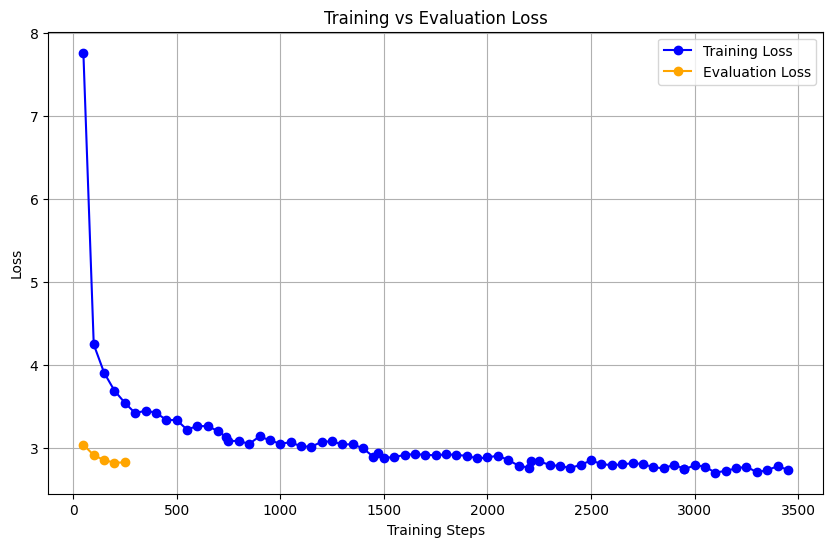

In [14]:
#Initialize training and evaluation loss metrics
train_loss = [] #Used to store training loss
eval_loss = [] #Used to store evaluation loss
eval_bleu = [] #Used to store eval bleu
eval_exact_match = [] #Used to store eval_exact_match
eval_rouge = [] #Used to store eval rouge
steps = [] #Used to store steps
eval_steps = [] #Used to store eval steps.

#Extract training metrics from log history
for log in log_history:
    if "loss" in log: #Check if loss is in log
        train_loss.append(log["loss"]) #Append training loss
        steps.append(log["step"]) #Append steps
    if "eval_loss" in log: #Check if eval_loss is in log
        eval_loss.append(log["eval_loss"]) #Append eval loss
        steps.append(log["step"]) #Append steps
    if "eval_BLEU" in log: #Check if eval_bleu is in log
        eval_bleu.append(log["eval_BLEU"]) #Append eval_bleu
    if "eval_ROUGE-L" in log: #Check if eval_rouge is in log
        eval_rouge.append(log["eval_ROUGE-L"]) #Append eval_rouge
    if "eval_exact_match" in log: #Check if exact match is in log
        eval_exact_match.append(log["eval_exact_match"]) #Append exact_match
#Plot the training and evaluation loss.
plt.figure(figsize=(10,6))
plt.plot(steps[:len(train_loss)] , train_loss, label="Training Loss", color="blue", marker="o") #Plot the training loss steps
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", color="orange", marker="o") #Plot the eval loss steps
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#Print length of steps, training loss and eval loss.
print(len(steps), len(train_loss), len(eval_loss))

78 73 5


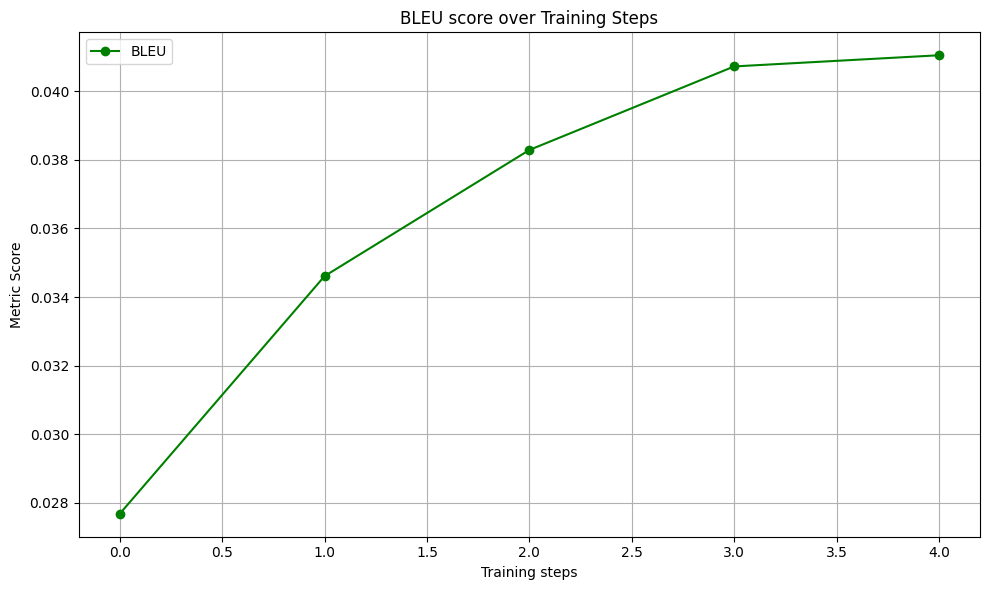

In [19]:
plt.figure(figsize=(10,6))
plt.plot(eval_steps, eval_bleu, label="BLEU", marker="o", linestyle="-", color="green") #Plot eval_steps and eval_bleu.
plt.xlabel("Training steps")
plt.ylabel("Metric Score")
plt.title("BLEU score over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

5 5


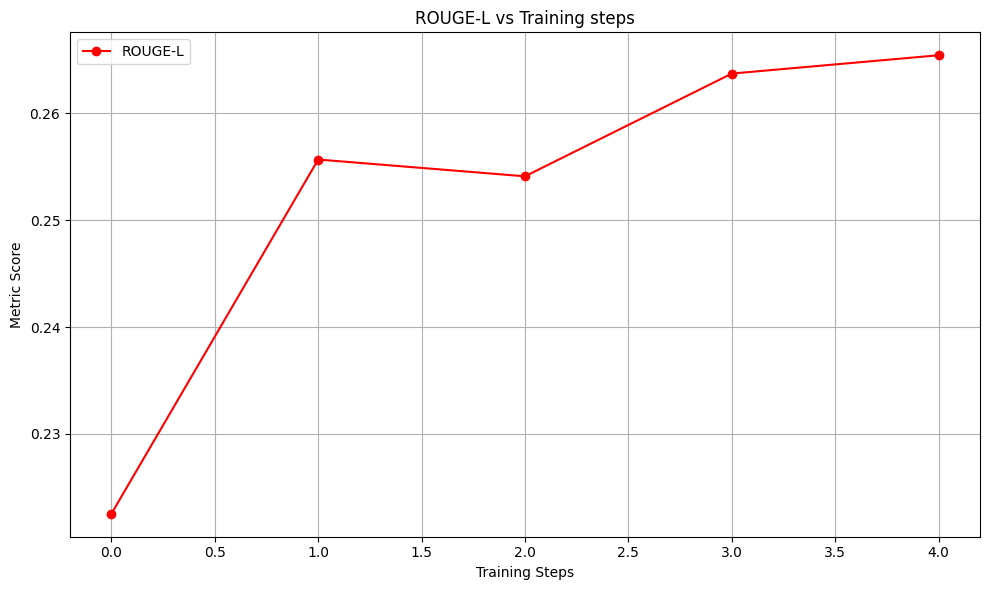

In [20]:
#Plot the rouge score
print(len(eval_steps), len(eval_rouge)) #Check the length of eval_steps and eval_rouge.
plt.figure(figsize=(10,6))
plt.plot(eval_steps, eval_rouge, label="ROUGE-L", marker="o", color="red", linestyle="-") #Plot eval_steps and eval_rouge
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("ROUGE-L vs Training steps")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

5 5


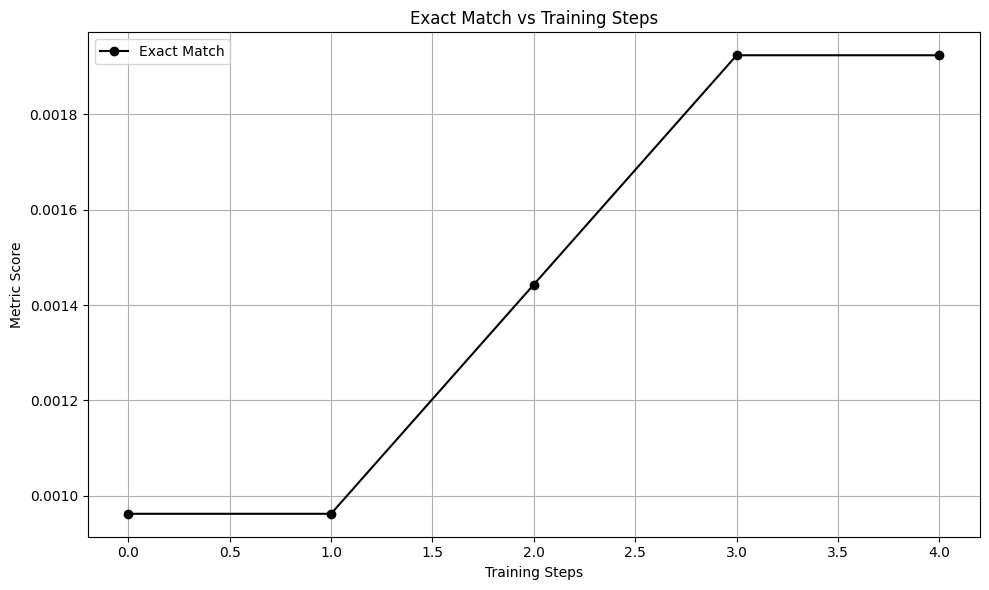

In [21]:
#Plot exact match scores
print(len(eval_steps), len(eval_exact_match)) #Make sure the length of eval_steps and exact match are the same.
plt.figure(figsize=(10,6))
plt.plot(eval_steps, eval_exact_match, label="Exact Match", color="black", linestyle="-", marker="o") #Plot eval_steps and eval_exact_match
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("Exact Match vs Training Steps")
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#Define paths to saved model
model_path = "t5_chatbot_model"
tokenizer_path = "t5_chatbot_tokenizer"
#Load the tokenizer and model from saved path
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
#Set the model to eval mode
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [23]:
#Generate a response using topk and top p sampling.
def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=256, top_k=50, top_p=0.95, temperature=1.0
):
    """
    question- input question, model- Pretrained language model, max_length- Max no. of tokens in the generated response,
    tokenizer of the associated model, top_k- Keeps the most likely next words, top_p- Keeps the smallest sum of words whose probabilities sum upto p(0.95)
    temperature- controls the randomness of predictions. 
    Temp >1.0 - More randomness(Chooses less probable words), Temp <1.0 - More deterministic(Picks highly probable words)
    """
    #Format the question for the model
    formatted_question = f"Question: {question}\nAnswer:"
    #Tokenize the input question
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt", #Return pytorch tensors
        padding=True, #Pad sequences to same length
        truncation=True, #Truncate sequences longer that max_length
        max_length=max_length, #Maximum length of the input
    )
    #Generate a response using top_k, top_p
    outputs = model.generate(
        input_ids=inputs["input_ids"], #Input token IDs
        attention_mask=inputs["attention_mask"], #Attention Mask to tell the model which tokens should be attended to and which one should be ignored.
        max_length=max_length, #Maximum length of generated response
        do_sample=True, #Enable sampling instead of greedy beam searching.
        top_k=top_k, #Top_k sampling token_ids
        top_p=top_p, #Considering smallest of token with cumulative probability >= top_p
        temperature=temperature, #Adjust randomness
        pad_token_id=tokenizer.pad_token_id, #Token ID for padding
    )
    #Decode the generated response into human readable string
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    return response

In [32]:
#Example usage
question = "What is Alzheimer's"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)

Question: What is Alzheimer's
Response: Alzheimer's is a very complex disease of the brain that affects about half of people. it causes some of the brain symptoms of the disease. it can affect people of all ages. people with Alzheimer's can develop dementia in a few weeks. the disease usually gets worse over time with increased activity, more frequent and frequent attacks, and worsened symptoms of this condition over a year or more. a lack of movement can have grave effects on people of all ages. people with Alzheimer's may also experience problems with feeding, sitting, and chewing. the same brain abnormalities may occur with Alzheimer's disease. some people with Alzheimer's have increased levels of calcium, sodium, potassium, potassium, and calcium in their urine . nih: national institute of neurological disorders and stroke


In [25]:
question = "What causes hypertension"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)

Question: What causes hypertension
Response: many factors can cause hypertension, including - genetics - environmental factors - certain types of drugs - certain types of infections - certain diseases - autoimmune diseases many factors trigger hypertension. these include - chronic and chronic kidney disease - certain genetic diseases - diseases that can increase the risk of hypertension, including osteoporosis, spheromegaly, and stroke - a family history of hypertension - genetic factors that affect your ability to gain weight and maintain a healthy weight - genetic factors that affect your health, including heart, hair, and teeth - genetic factors that influence your risk for hypertension, such as diabetes and obesity - genetic factors that can trigger hypertension, such as tobacco exposures - high cholesterol, a family history of hypertension - diabetes and obesity, such as diabetes, high blood cholesterol, and blood pressure, such as diabetes and prediabetes - pregnancy risk factors

In [26]:
question = "What is the physical examination of prostate cancer"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)

Question: What is the physical examination of prostate cancer
Response: your doctor will ask about your symptoms as you go through an exam. a health care provider probably will order a physical exam at an advanced stage to check for prostate cancer. a physical exam is a test that checks the body's response to new situations and how well the body's cells work. it might include: - the size of the ureter: a series of detailed pictures. a sample of prostate tissue is taken of the skin, groin, and kidneys. the test measures how well the prostate is working. - the type of prostate cancer the doctor or nurse removes the patient's prostate, and he or she then inserts the sample of tissue out of the bloodstream. the samples are then scanned through the machine. the procedure happens after treatment is completed. the samples are then transferred to the test lab for analysis.


In [27]:
question = "How can you treat prostate cancer"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)

Question: How can you treat prostate cancer
Response: your treatment options can depend on your overall health, the risk for prostate cancer, the stage of the cancer, the signs and symptoms that your cancer has, and whether you have symptoms. prostate cancer also is a tough tumor. most people who receive early treatment do not need treatment. treatment is very important. in most cases, you'll treat men who have it. during a prostate exam, you'll examine your urine and blood in a machine. for example, your doctor might ask you to check your prostate. for example, a biopsy is a procedure you take to remove debris from the prostate. the process is similar to that of a tumor cell. you can also take a sample of tissue from the prostate into a machine and have a sample of tissue from your prostate. the sample contains more than 200 images. more than 100 videos are made every year, and it's good for the picture. if you feel sad after the procedure, your doctor may ask questions about your bow

In [28]:
question = "I feel dizzy and light headed, what might be the problem?"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)

Question: I feel dizzy and light headed, what might be the problem?
Response: my body is not always aware of the signs and symptoms of dizzy or lightheadedness. when the fainting is due to it, my body does not respond well to its signals. however, my mind is usually completely clear. the problem is usually the symptoms of light headed and dizzy situations. some people are at an increased risk for dizziness and lightheadedness. others may have a mild or no dizziness, but are very happy to talk with their health care provider.


In [29]:
question = "I fell down and hurt my knee. I now do physiotherapy but the pain is still there. What should I do?"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)

Question: I fell down and hurt my knee. I now do physiotherapy but the pain is still there. What should I do?
Response: key points - you are reading about my falling down and hurting my knee during my yoga class. - you've made choices about how to - keep your joints healthy - find your comfort zone with physiotherapy. - keep your knees healthy to get as much rest as you can. - remember your posture at yoga class. - avoid contact with your feet. - wash your hands frequently, even when you walk. - follow the instructions on a regular basis.


In [30]:
question = "What is glaucoma?"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)

Question: What is glaucoma?
Response: glaucoma is an eye problem that affects the glaucoma type of skin. you may have a tint to the eye called red or grayish patches, which may be a sign of damage or discomfort. glaucoma affects more than half the world's population, affecting about 50 percent of the world's population. some of these spots are caused by bacteria and viruses, causing an increased risk of infections or allergies. some of these spots are due to the development of a skin cancer called microtrauma. otherglaucoma is usually malignant. it occurs most often on the scalp. it is found at all the scalp, but it does not affect everyone's eyes. eye problems are more common in people with glaucoma than other eye conditions. if you have symptoms, you may be younger than 18 years of age and have normal eyesight. but if you are overweight or have symptoms other than blindness, you may have symptoms. glaucoma can be hard to treat. but they can be difficult to diagnose, and treatments de

In [ ]:
#since the responses we are getting are gibberish, it is better to get a response from BioGPT

In [36]:
pip install transformers torch accelerate

Note: you may need to restart the kernel to use updated packages.


In [201]:
import os
os.environ["HF_HUB_READ_TIMEOUT"] = "60"
os.environ["HF_HUB_READ_CONNECT_TIMEOUT"] = "60"

In [202]:
#Load BioGPT
from transformers import BioGptTokenizer, BioGptForCausalLM
model_name = "microsoft/BioGPT-Large"
tokenizer = BioGptTokenizer.from_pretrained(model_name)
model = BioGptForCausalLM.from_pretrained(model_name)

In [203]:
model.eval()

BioGptForCausalLM(
  (biogpt): BioGptModel(
    (embed_tokens): BioGptScaledWordEmbedding(57717, 1600, padding_idx=1)
    (embed_positions): BioGptLearnedPositionalEmbedding(2050, 1600)
    (layers): ModuleList(
      (0-47): 48 x BioGptDecoderLayer(
        (self_attn): BioGptSdpaAttention(
          (k_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (v_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (q_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1600, out_features=6400, bias=True)
        (fc2): Linear(in_features=6400, out_features=1600, bias=True)
        (final_layer_norm): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((

In [213]:
def generate_detailed_medical_response(question, tokenizer, model, max_length=200, max_new_tokens=200):
    formatted_question = (
        f"Title: {question}\n"
        f"Abstract:"
    )
    
    
    #Tokenize the input question
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt", #Return pytorch tensors
        padding=True, #Pad sequences to same length
        truncation=True, #Truncate sequences longer that max_length
        max_length=max_length, #Maximum length of the input
    )
    
    # Generating the output from the model
    outputs = model.generate(
        input_ids=inputs["input_ids"],  # Accessing the input IDs
        attention_mask=inputs["attention_mask"],  # Using the attention mask
        max_new_tokens=max_new_tokens,  # Defining the max length for new tokens
        do_sample=False, 
        num_beams=5,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
    )
       
    # Decoding the output
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = decoded.replace(formatted_question, "").strip()
    return response

In [209]:
question = "What is Alzheimer's disease?"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: What is Alzheimer's disease?
Response: Title: What is Alzheimer's disease? Abstract: Alzheimer's disease (AD) is the most common cause of dementia in the elderly. It is characterized by the presence of amyloid plaques and neurofibrillary tangles (NFTs) in the brain. The amyloid plaques are composed of amyloid-β (Aβ) peptides, which are derived from the amyloid precursor protein (APP) by sequential cleavage by β-secretase and γ-secretase. The NFTs are composed of hyperphosphorylated forms of the microtubule-associated protein tau, which is encoded by the microtubule-associated protein tau (MAPT) gene. < / FREETEXT > < / PARAGRAPH > ▃ < PARAGRAPH > < FREETEXT > Mutations in the APP, presenilin 1 (PSEN1), and presenilin 2 (PSEN2) genes have been identified in families with early-onset AD (EOAD). The APP gene is located on chromosome 2 1, and the PSEN1 and PSEN2 genes are located on chromosomes 1 4 and 1, respectively. Mutations in the APP, PSEN1, and PSEN2 genes have been identi

In [210]:
question = "What is glaucoma?"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: What is glaucoma?
Response: Title: What is glaucoma? Abstract: Glaucoma is the second leading cause of blindness worldwide. Glaucoma is a group of optic neuropathies characterized by progressive loss of retinal ganglion cells (RGCs) and their axons in the optic nerve head (ONH), leading to visual field loss and eventual blindness. Glaucoma can be classified into primary open-angle glaucoma (POAG), primary angle-closure glaucoma (PACG), and normal-tension glaucoma (NTG). POAG is the most common form of glaucoma, accounting for 7 0% to 8 0% of all glaucoma cases. PACG accounts for 1 0% to 1 5% of all glaucoma cases, and NTG accounts for 5% to 1 0% of all glaucoma cases. POAG is characterized by an insidious loss of RGCs and their axons in the ONH, leading to visual field loss and eventual blindness. PACG is characterized by an acute or subacute loss of RGCs and their axons in the ONH, leading to visual field loss and eventual blindness. NTG is characterized by a gradual loss


In [216]:
question = "What is multiple sclerosis?"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)a

Question: What is multiple sclerosis?
Response: Title: What is multiple sclerosis? Abstract: Multiple sclerosis (MS) is a chronic inflammatory demyelinating disease of the central nervous system (CNS). It is the most common cause of nontraumatic neurological disability in young adults in the United States and Europe. The etiology of MS is unknown, but it is thought to be caused by a combination of genetic and environmental factors. The clinical course of MS is highly variable, with some patients experiencing a relapsing-remitting course and others experiencing a chronic progressive course. The diagnosis of MS is based on the clinical history and examination, supported by magnetic resonance imaging (MRI) of the brain and spinal cord, cerebrospinal fluid (CSF) analysis, and, in some cases, evoked potential testing. The treatment of MS is based on the clinical course of the disease. For patients with relapsing-remitting MS, disease-modifying therapies (DMTs) are used to reduce the frequen

In [218]:
question = "What is multiple sclerosis?"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: What is multiple sclerosis?
Response: Title: What is multiple sclerosis? Abstract: Multiple sclerosis (MS) is a chronic inflammatory demyelinating disease of the central nervous system (CNS). It is the most common cause of nontraumatic neurological disability in young adults in the United States and Europe. The etiology of MS is unknown, but it is thought to be caused by a combination of genetic and environmental factors. The clinical course of MS is highly variable, with some patients experiencing a relapsing-remitting course and others experiencing a chronic progressive course. The diagnosis of MS is based on the clinical history and examination, supported by magnetic resonance imaging (MRI) of the brain and spinal cord, cerebrospinal fluid (CSF) analysis, and, in some cases, evoked potential testing. The treatment of MS is based on the clinical course of the disease. For patients with relapsing-remitting MS, disease-modifying therapies (DMTs) are used to reduce the frequen

In [221]:
question = "What is quantum thermodynamics"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: What is quantum thermodynamics
Response: Title: What is quantum thermodynamics Abstract: In this paper, we introduce the concept of quantum thermodynamics in the context of quantum information processing (QIP). In QIP, information is encoded in the quantum state of a physical system, and the information is processed by a quantum computer. In this paper, we introduce the concept of quantum thermodynamics in the context of quantum information processing (QIP). In QIP, information is encoded in the quantum state of a physical system, and the information is processed by a quantum computer. In this paper, we introduce the concept of quantum thermodynamics in the context of quantum information processing (QIP). In QIP, information is encoded in the quantum state of a physical system, and the information is processed by a quantum computer. In this paper, we introduce the concept of quantum thermodynamics in the context of quantum information processing (QIP). In QIP, information is 

In [222]:
question = "Explain the tariffs war using Schrodinger's cat analogy"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: Explain the tariffs war using Schrodinger's cat analogy
Response: Title: Explain the tariffs war using Schrodinger's cat analogy Abstract: In the tariffs war, the United States spent more than $1 trillion on health care in 2 0 1 6. The war on the tariffs has been the subject of much debate in the United States and around the world. In this article, we use Schrodinger's cat analogy to explain the tariffs war on the tariffs. < / FREETEXT > < / PARAGRAPH > ▃ < PARAGRAPH > < FREETEXT > Keywords: < / FREETEXT > < / PARAGRAPH > ▃ < PARAGRAPH > < FREETEXT > tariffs, tariffs war, Schrodinger cat analogy < / FREETEXT > < / PARAGRAPH > ▃
